# Deep Learning for tensiometry of pendant drop

### Import necessary packages and self-defined classes

In [2]:
# pyplot
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
#Test/Train data split
from functools import lru_cache
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import logging
# sklearn
from sklearn import preprocessing
# os
import os
# warnings
import warnings
warnings.filterwarnings('ignore')
# random
import random
# math
import math

# self-defined model
from model_pic import *
from model_cal import *
import pandas as pd

#PictureNet
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split

## Dataset loading and preprocessing

In [3]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[:validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
    
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train dataloader')
        self.train_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing validation dataloader')
        self.val_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing test dataloader')
        self.test_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

### Load data for PhysicsNet

         0         1          2         3         4         5         6   \
0      15.1   5.10061  14.150364  0.641996  0.560755 -0.204328 -0.058190   
1      15.1   5.20122  13.846032  0.643660  0.560057 -0.206831 -0.056986   
2      15.1   5.30183  13.542532  0.645277  0.559330 -0.209271 -0.055732   
3      15.1   5.40244  13.239690  0.646846  0.558572 -0.211646 -0.054425   
4      15.1   5.50305  12.937316  0.648367  0.557781 -0.213957 -0.053062   
...     ...       ...        ...       ...       ...       ...       ...   
24742  86.1  25.28098  68.539411  0.889489  0.557742 -0.559551 -0.052669   
24743  86.1  25.81469  67.593048  0.892798  0.556636 -0.564524 -0.050794   
24744  86.1  26.34840  66.662881  0.896025  0.555496 -0.569388 -0.048861   
24745  86.1  26.88211  65.747951  0.899170  0.554318 -0.574146 -0.046868   
24746  86.1  27.41582  64.847338  0.902236  0.553103 -0.578799 -0.044812   

             7         8         9   ...        15        16        17  \
0      0.0735

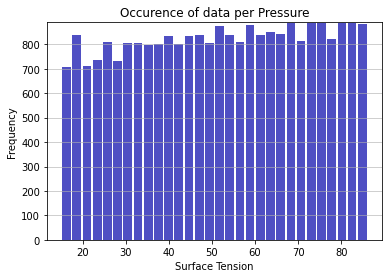

In [32]:
data_matrix = df = pd.DataFrame()

# data_matrix = pd.read_csv("Data_folder/Data_Spline/Spline.csv", header= None)
data_matrix = pd.read_csv("Data_uniform/SplineV3.csv", header= None)


print(data_matrix)


# Make the droplet dataset class based on data_matrix
class Droplet_data_set(Dataset):
    def __init__(self):
        x = data_matrix.iloc[0:,3:].values
        y = data_matrix.iloc[0:,0:2].values

        ###### Data distribution visualization ######
        # x = np.random.normal(x,0.01)
        # y0 is surface tension,  y1 is pressure
        y0 = data_matrix.iloc[:,0].values
        y1 = data_matrix.iloc[:,1].values
        
        # Add normalization for x
        # x = preprocessing.normalize(x)
        # y = preprocessing.normalize(y, axis = 0,norm='l2')
        n, bins, patches = plt.hist(x=y0, bins='auto', color='#0504aa',
                                    alpha=0.7, rwidth=0.85)
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Surface Tension')
        # plt.xlabel('Volume[mm^3]')
        plt.ylabel('Frequency')
        plt.title('Occurence of data per Pressure')
        
        maxfreq = n.max()
        # Set a clean upper y-axis limit.
        plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
        ##############################################

        self.x_train = torch.tensor(x,dtype=torch.float32)
        self.y_train = torch.tensor(y,dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.x_train[idx],self.y_train[idx]
    
    def __len__(self):
         return len(self.y_train)
        
my_data_set = Droplet_data_set()

# Split the single dataset into 3 datasets for training, test and validation.
split = DataSplit(my_data_set, shuffle=True)
train_loader, val_loader, test_loader = split.get_split(batch_size=512, num_workers=0)


### Load data for PictureNet
Read image from files

In [33]:
train_img = []

# data_image = pd.read_csv("Data_folder/Picture.csv", header= None)       # Small dataset
data_image = pd.read_csv("Data_uniform/SplineV3.csv", header= None) # Large dataset
for img_name in data_image.iloc[0:,3:].index + 1:      # modify the number depends on size of dataset
    # defining the image path
    image_path = 'Data_uniform/' + str(img_name) + '.png'      # modify the path depends on which dataset
    # reading the image
    img = imread(image_path, as_gray=True)
    img = img[4:-4, 4:-4]  #crop 
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

Plot a single image for viewing

Current image = 4702
Picture size = (82, 77)


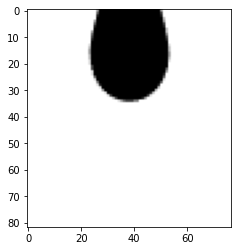

In [34]:
rand = random.randint(0, 24747)
print("Current image =", rand)
print("Picture size =", train_img[rand].shape)
plt.imshow(train_img[rand], cmap='gray')

In [53]:
# converting the list to numpy array
train_x_pic = np.array(train_img)
train_y_pic = data_image.iloc[0:,3:].values            # modify the number depends on size of dataset
train_x_pic, rem_x_pic, train_y_pic, rem_y_pic = train_test_split(train_x_pic, train_y_pic, test_size = 0.2)    # default shuffle = True
val_x_pic, test_x_pic, val_y_pic, test_y_pic = train_test_split(rem_x_pic, rem_y_pic, test_size = 0.5)
len(train_x_pic)
# converting the trian images and targets into torch format
train_x_pic = train_x_pic.reshape(len(train_x_pic), 1, 82, 77)
train_x_pic  = torch.from_numpy(train_x_pic)
train_y_pic = torch.from_numpy(train_y_pic)
# print(train_x_pic.shape, train_y_pic.shape)

# converting the val images and targets into torch format
val_x_pic = val_x_pic.reshape(len(val_x_pic), 1, 82, 77)
val_x_pic  = torch.from_numpy(val_x_pic)
val_y_pic = torch.from_numpy(val_y_pic)
# print(val_x_pic.shape, val_y_pic.shape)

# converting the test images and targets into torch format
test_x_pic = test_x_pic.reshape(len(test_x_pic), 1, 82, 77)
test_x_pic  = torch.from_numpy(test_x_pic)
test_y_pic = torch.from_numpy(test_y_pic)
# print(test_x_pic.shape, test_y_pic.shape)

# converting the dataset into mini-batch dataset (input 4D -> 5D and 2D -> 3D)
def batch_transform(dataset, batch_size=512):
    batch = []
    batch_num = math.ceil(len(dataset)/batch_size)
    for i in range(batch_num):
        if len(dataset) == 4:
            if i < batch_num:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :, :, :])
            else:
                batch.append(dataset[i*batch_size:, :, :, :])
        else:
            if i < batch_num - 1:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :])
            else:
                batch.append(dataset[i*batch_size:, :])
    return batch

train_x_pic = batch_transform(train_x_pic)
train_y_pic = batch_transform(train_y_pic)
val_x_pic = batch_transform(val_x_pic)
val_y_pic = batch_transform(val_y_pic)
test_x_pic = batch_transform(test_x_pic)
test_y_pic = batch_transform(test_y_pic)
print(len(train_x_pic), len(train_y_pic), len(val_x_pic), len(val_y_pic), len(test_x_pic), len(test_y_pic))

39 39 5 5 5 5


### Deside to apply host or device


In [36]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#device = torch.device('cpu')
print(device)

cuda


## Define the functions

In [37]:
def loss_cal_phiysics(loss_list, model, loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def loss_cal_picture(loss_list, model, x_dataset, y_dataset):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t in range(len(x_dataset)):
            x = x_dataset[t]
            y = y_dataset[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch.cpu().data.numpy()/t)

def prediction(model, x):   # only a batch
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float32)
        score = torch.Tensor.cpu(model(x))
    return score

def model_selection(model, path, loss, epoch_current, epoch_ref, loss_ref):
    loss_best = loss_ref
    epoch_best = epoch_ref
    if epoch_current == 0:
            loss_current = loss[epoch_current]
            loss_best = loss[epoch_current]
            torch.save(model, path)
    else:
        loss_current = loss[epoch_current]
        if loss_current <= (loss_best * 1.1):   # 10% margin to get better fitting but a bit more loss
            loss_best = loss_current
            epoch_best = epoch_current
            torch.save(model, path)
    return loss_best, epoch_best

def train_physics(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0
    PATH_CAL = os.path.join(os.getcwd(), "model_cal_spline.pt")
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x = x.reshape(len(x), 1, 1, -1)     # reshape to 4D data for formal input of model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_phiysics(loss_train, model, train_loader)
        loss_cal_phiysics(loss_val, model, val_loader)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))

        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_CAL, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs",fontsize = 15)
    plt.ylabel("MSE Loss",fontsize = 15)
    plt.title("Train/Validation Loss",fontsize = 15)
    plt.legend(fontsize = 15)
    plt.show()

def train_picture(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0
    PATH_PIC = os.path.join(os.getcwd(), "model_pic_spline.pt")
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(len(train_x_pic)):
            model.train()  # put model to training mode
            x = train_x_pic[t]
            y = train_y_pic[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_picture(loss_train, model, train_x_pic, train_y_pic)
        loss_cal_picture(loss_val, model, val_x_pic, val_y_pic)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))

        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_PIC, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs",fontsize = 15)
    plt.ylabel("MSE Loss",fontsize = 15)
    plt.title("Train/Validation Loss",fontsize = 15)
    plt.legend(fontsize = 15)
    plt.show()


## Train PhysicsNet

epoch 1: train_loss = 1774.3254, val_loss = 2298.6973
epoch 2: train_loss = 1721.6545, val_loss = 2232.2275
epoch 3: train_loss = 1695.7173, val_loss = 2199.9036
epoch 4: train_loss = 1638.9913, val_loss = 2126.1167
epoch 5: train_loss = 1541.1350, val_loss = 1995.0897
epoch 6: train_loss = 1575.4273, val_loss = 2041.0371
epoch 7: train_loss = 1423.5160, val_loss = 1842.9596
epoch 8: train_loss = 1330.8033, val_loss = 1726.6294
epoch 9: train_loss = 1302.7219, val_loss = 1689.4092
epoch 10: train_loss = 1246.0539, val_loss = 1617.5706
epoch 11: train_loss = 1129.0420, val_loss = 1461.4341
epoch 12: train_loss = 1162.6477, val_loss = 1507.4066
epoch 13: train_loss = 927.0951, val_loss = 1192.2422
epoch 14: train_loss = 906.9350, val_loss = 1178.7750
epoch 15: train_loss = 839.6621, val_loss = 1086.3685
epoch 16: train_loss = 684.8634, val_loss = 876.6681
epoch 17: train_loss = 795.6502, val_loss = 1033.3486
epoch 18: train_loss = 564.0071, val_loss = 724.1645
epoch 19: train_loss = 564.

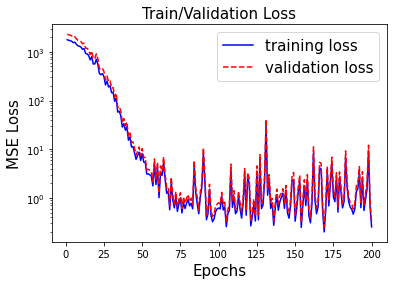

In [39]:
in_channel = 22
node_1 = 1024
node_2 = 1024
node_3 = 512
node_4 = 256
node_5 = 64
node_6 = 16
out_channel = 2

learning_rate = 1e-3

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, node_5, node_6, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 200

train_physics(model_physics, optimizer, epoch)


### Visualization of outcomes

In [40]:
PATH_CAL = os.path.join(os.getcwd(), "model_cal_spline.pt")
model_physics_trained = torch.load(PATH_CAL)

examples = enumerate(test_loader)
_, (x_test_example, y_test_example) = next(examples)

score_example = prediction(model_physics_trained, x_test_example)
# y = data_matrix.iloc[0:,0:2].values
#Revert normalized values back to real values
# Print only 8 data samples for comparison
print("Ground Truths =", y_test_example[:15])
print("Prediction    =", score_example[:15].reshape(15, 2))

Ground Truths = tensor([[39.3000, 11.4540],
        [75.7000, 23.8108],
        [82.1000, 25.3724],
        [82.9000, 35.8514],
        [76.0000, 26.2445],
        [58.0000, 23.1150],
        [84.1000, 30.0325],
        [61.1000, 21.7732],
        [80.3000, 26.9265],
        [39.4000, 17.9397],
        [30.8000, 12.2661],
        [50.7000, 19.6174],
        [83.0000, 36.9176],
        [15.3000,  6.6293],
        [82.7000, 32.7004]])
Prediction    = tensor([[39.5393, 11.2662],
        [76.3766, 23.5133],
        [82.4792, 24.7653],
        [82.7233, 35.8574],
        [76.3994, 25.9436],
        [58.6302, 23.0278],
        [84.0276, 29.5495],
        [62.0011, 21.6101],
        [80.2680, 26.2640],
        [39.1964, 17.9732],
        [30.1559, 12.1435],
        [50.9515, 19.5655],
        [82.9673, 37.0977],
        [16.5110,  7.1031],
        [82.8606, 32.0233]])


## Train PictureNet

epoch 1: train_loss = 0.2590, val_loss = 0.3170
epoch 2: train_loss = 0.1885, val_loss = 0.2309
epoch 3: train_loss = 0.0123, val_loss = 0.0152
epoch 4: train_loss = 0.0012, val_loss = 0.0014
epoch 5: train_loss = 0.0023, val_loss = 0.0028
epoch 6: train_loss = 0.0015, val_loss = 0.0018
epoch 7: train_loss = 0.0214, val_loss = 0.0263
epoch 8: train_loss = 0.0008, val_loss = 0.0009
epoch 9: train_loss = 0.0050, val_loss = 0.0061
epoch 10: train_loss = 0.0009, val_loss = 0.0011
epoch 11: train_loss = 0.0029, val_loss = 0.0036
epoch 12: train_loss = 0.0002, val_loss = 0.0003
epoch 13: train_loss = 0.0005, val_loss = 0.0005
epoch 14: train_loss = 0.0071, val_loss = 0.0087
epoch 15: train_loss = 0.0005, val_loss = 0.0007
epoch 16: train_loss = 0.0015, val_loss = 0.0018
epoch 17: train_loss = 0.0130, val_loss = 0.0161
epoch 18: train_loss = 0.0090, val_loss = 0.0110
epoch 19: train_loss = 0.0002, val_loss = 0.0002
epoch 20: train_loss = 0.0021, val_loss = 0.0025
epoch 21: train_loss = 0.0046

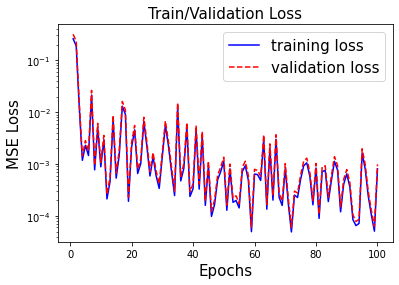

In [54]:
in_channel = 1
channel_1 = 16
channel_2 = 32
channel_3 = 64
node_1 = 512
node_2 = 512
out_channel = 22

learning_rate = 1e-4

model_picture = PictureNet(in_channel, channel_1, channel_2, channel_3, node_1, node_2, out_channel)
optimizer = optim.Adam(model_picture.parameters(), lr=learning_rate)
epoch = 100

train_picture(model_picture, optimizer, epoch)

### Visualization of outcomes

In [57]:
# testing cell for better viewing the length
train_x_pic, train_y_pic

print(len(train_x_pic))
print(train_x_pic[0].shape)
print(train_y_pic[0].shape)

39
torch.Size([512, 1, 82, 77])
torch.Size([512, 22])


In [88]:
PATH_PIC = os.path.join(os.getcwd(), "model_pic_spline.pt")
model_picture_trained = torch.load(PATH_PIC)

#Load YC matrix for point values
data_YC = pd.read_csv("Data_folder/YC.csv", header= None)
YC = torch.Tensor(data_YC.values)

rand1 = random.randint(0, len(test_x_pic)-1)
rand2 = random.randint(0, 63)

print("current batch =", rand1)
print("current testing image =", rand2)

score_pic_pred = prediction(model_picture_trained, test_x_pic[rand1][rand2].reshape(1, 1, 82, 77))

#Multiply the found Chebyshev coefficients with YC matrix to obtain edge points
score_pic_r = torch.matmul(YC ,score_pic_pred[0, 0:11]) 
score_pic_z = torch.matmul(YC ,score_pic_pred[0, 11:22])

test_y_pic_r = torch.matmul(YC ,test_y_pic[rand1][rand2][0:11].float()) 
test_y_pic_z = torch.matmul(YC ,test_y_pic[rand1][rand2][11:22].float()) 

for num in range(len(test_y_pic_r)):
   print(num+1, ": Ground Truths =", test_y_pic_z[num].item(), ", Prediction =", score_pic_z[num].item())


current batch = 4
current testing image = 60
1 : Ground Truths = -4.8864426612854 , Prediction = -4.866032600402832
2 : Ground Truths = -4.885340690612793 , Prediction = -4.8617658615112305
3 : Ground Truths = -4.885656833648682 , Prediction = -4.857504367828369
4 : Ground Truths = -4.884160995483398 , Prediction = -4.853185176849365
5 : Ground Truths = -4.878998756408691 , Prediction = -4.847545146942139
6 : Ground Truths = -4.8683953285217285 , Prediction = -4.838200569152832
7 : Ground Truths = -4.850072860717773 , Prediction = -4.821920871734619
8 : Ground Truths = -4.821178913116455 , Prediction = -4.795007705688477
9 : Ground Truths = -4.7784881591796875 , Prediction = -4.7537055015563965
10 : Ground Truths = -4.718752861022949 , Prediction = -4.694584846496582
11 : Ground Truths = -4.6390886306762695 , Prediction = -4.614863395690918
12 : Ground Truths = -4.537309169769287 , Prediction = -4.512640953063965
13 : Ground Truths = -4.41218376159668 , Prediction = -4.387048721313477


### Plot the ground truth and prediction to make a comparison

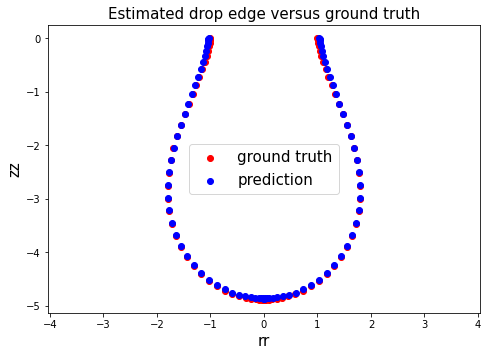

In [90]:
# scattering points for ground truth
gt_r_pos = test_y_pic_r
gt_r_neg = -torch.flip(test_y_pic_r, [0])
gt_z_pos = test_y_pic_z
gt_z_neg = torch.flip(test_y_pic_z, [0])
gt_r = torch.cat((gt_r_neg, gt_r_pos))
gt_z = torch.cat((gt_z_neg, gt_z_pos))

# scattering points for prediction
pred_r_pos = score_pic_r
pred_r_neg = -torch.flip(score_pic_r, [0])
pred_z_pos = score_pic_z
pred_z_neg = torch.flip(score_pic_z, [0])
pred_r = torch.cat((pred_r_neg, pred_r_pos))
pred_z = torch.cat((pred_z_neg, pred_z_pos))

# plotting
fig = plt.figure()
a1 = fig.add_axes([0,0,1,1])
a1.set_xlim(0,3)
a1.set_title("Estimated drop edge versus ground truth", fontsize = 15)
plt.scatter(gt_r, gt_z, c="red", label="ground truth")
plt.scatter(pred_r, pred_z, c="blue", label="prediction")

plt.xlabel("rr",fontsize = 15)
plt.ylabel("zz",fontsize = 15)
plt.legend(fontsize = 15)
plt.axis('equal')
plt.show()